<a href="https://colab.research.google.com/github/AhmedAsaad272/Final-Project/blob/main/feedforward_(Reducing_number_of_neurons).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [58]:

# mount drive so that we can use the dataset from google drive

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
!ls "/content/drive/My Drive/Dataset"

testing  training


In [60]:
# Applying Transforms to the Data
image_transforms = { 
    'train': transforms.Compose([
        transforms.Resize(size=(32,32)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=(32,32)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=(32,32)),
        transforms.ToTensor(),
    ])
}

In [145]:
# Load the Data

# Set train and valid directory paths

dataset = '/content/drive/My Drive/Dataset'

train_directory = os.path.join(dataset, 'training')
valid_directory = os.path.join(dataset, 'testing')
test_directory = os.path.join(dataset, 'testing')

# Batch size
batchSize = 32

# Number of classes
# num_classes = len(os.listdir(valid_directory))-1  
num_classes = len(os.listdir(valid_directory))
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

5
{0: 'bracelet', 1: 'earring', 2: 'necklace', 3: 'nose ring', 4: 'ring'}


In [62]:
data['train']

Dataset ImageFolder
    Number of datapoints: 3150
    Root location: /content/drive/My Drive/Dataset/training
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=PIL.Image.BILINEAR)
               RandomRotation(degrees=[-15.0, 15.0], resample=False, expand=False)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [63]:
# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=batchSize, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=batchSize, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=batchSize, shuffle=True)

In [64]:
train_data_size, valid_data_size, test_data_size

(3150, 1350, 1350)

In [65]:
input_size = 32*32*3   #3072 neurons

In [129]:
class ourModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.linear1 = nn.Linear(input_size, 100)
        # hidden layers
        self.linear2 = nn.Linear(100, 50)
        self.linear3 = nn.Linear(50, 20)
        # output layer
        self.linear4 = nn.Linear(20, num_classes)
        # Define proportion or neurons to dropout
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, xb):
        # Flatten images into vectors
        out = xb.view(xb.size(0), -1)
        # Apply layers & activation functions
        out = self.linear1(out)
        # Apply activation function
        out = torch.sigmoid(out)
        # Apply dropout
        #out = self.dropout(out)
        # Get intermediate outputs using hidden layer 2
        out = self.linear2(out)
        # Apply activation function
        out = torch.sigmoid(out)
        # Apply dropout
        #out = self.dropout(out)
        # Get predictions using output layer
        out = self.linear3(out)
        # Apply activation function
        out = torch.sigmoid(out)
        # Apply dropout
        #out = self.dropout(out)
        # Get predictions using output layer
        out = self.linear4(out)
        # Apply activation function
        out = torch.sigmoid(out)
        return out

In [130]:
model = ourModel(input_size, num_classes)

model = model.to('cuda:0')

In [131]:
model

ourModel(
  (linear1): Linear(in_features=3072, out_features=100, bias=True)
  (linear2): Linear(in_features=100, out_features=50, bias=True)
  (linear3): Linear(in_features=50, out_features=20, bias=True)
  (linear4): Linear(in_features=20, out_features=5, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

In [133]:
# Define Optimizer and Loss Function
learning_rate = 0.01 # 0.0000001
loss_func = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [134]:
def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_data_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/valid_data_size 
        avg_valid_acc = valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
       # torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history
    

In [135]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [136]:
device

device(type='cuda', index=0)

In [137]:
# Train the model for 25 epochs
num_epochs = 50
trained_model, history = train_and_validate(model, loss_func, optimizer, num_epochs)

#torch.save(history, dataset+'_history.pt')

Epoch: 1/50


/usr/local/lib/python3.6/dist-packages/PIL/Image.py:932: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Epoch : 000, Training: Loss: 1.6122, Accuracy: 19.5873%, 
		Validation : Loss : 1.6097, Accuracy: 20.0000%, Time: 10.5379s
Epoch: 2/50
Epoch : 001, Training: Loss: 1.6106, Accuracy: 18.9524%, 
		Validation : Loss : 1.6096, Accuracy: 20.0000%, Time: 11.4523s
Epoch: 3/50
Epoch : 002, Training: Loss: 1.6100, Accuracy: 18.8889%, 
		Validation : Loss : 1.6095, Accuracy: 20.0000%, Time: 11.0426s
Epoch: 4/50
Epoch : 003, Training: Loss: 1.6101, Accuracy: 18.9524%, 
		Validation : Loss : 1.6095, Accuracy: 20.0000%, Time: 10.5765s
Epoch: 5/50
Epoch : 004, Training: Loss: 1.6098, Accuracy: 19.3333%, 
		Validation : Loss : 1.6094, Accuracy: 20.0741%, Time: 10.4939s
Epoch: 6/50
Epoch : 005, Training: Loss: 1.6098, Accuracy: 20.1905%, 
		Validation : Loss : 1.6096, Accuracy: 20.0000%, Time: 10.5078s
Epoch: 7/50
Epoch : 006, Training: Loss: 1.6102, Accuracy: 18.5397%, 
		Validation : Loss : 1.6095, Accuracy: 19.7778%, Time: 10.5261s
Epoch: 8/50
Epoch : 007, Training: Loss: 1.6100, Accuracy: 19.8730%

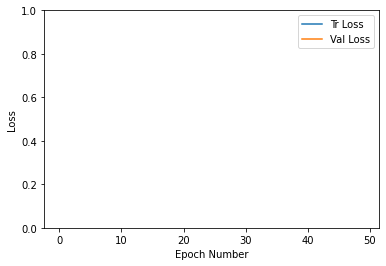

In [146]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()


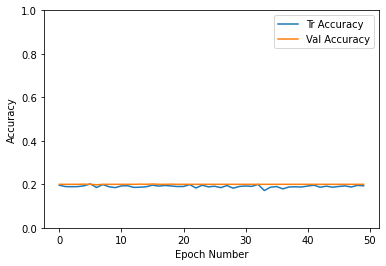

In [147]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

In [141]:
 def computeTestSetAccuracy(model, loss_criterion):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0

    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # Find average test loss and test accuracy
    avg_test_loss = test_loss/test_data_size 
    avg_test_acc = test_acc/test_data_size

    print("Test accuracy : " + str(avg_test_acc))


In [142]:
def predict(model, test_image_name):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    
    transform = image_transforms['test']

    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    test_image_tensor = transform(test_image)

    if torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 32, 32).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 32, 32)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        ps = torch.exp(out)
        topk, topclass = ps.topk(3, dim=1)
        for i in range(3):
            print("Prediction", i+1, ":", idx_to_class[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i])




In [143]:
# Test a particular model on a test image

#dataset = '/content/drive/My Drive/test/'
#model = torch.load('/content/drive/My Drive/01. TEACHING/MACHINE_VISION/code/fruit_dataset_model_49.pt')
#predict(model, dataset+'pumpkin/0a53555962a12877a40280e6d38cc4019bd4050f.jpg')           
        

In [144]:
# Load Data from folders
#computeTestSetAccuracy(model, loss_func)